In [39]:
%matplotlib inline
import numpy as np
import h5py
import os,sys
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from heapq import heappushpop, heappush, heappop 
import bezier

In [2]:
sys.setrecursionlimit(50000)

In [3]:
def readh5(filename, datasetname='main', rr=[1,1,1]):
    fid=h5py.File(filename,'r')
    if isinstance(datasetname, (list,)):
        out = [None] *len(datasetname)
        for i,dd in enumerate(datasetname):
            sz = len(fid[dd].shape)
            if sz==2:
                out[i] = np.array(fid[dd][::rr[0],::rr[1]])
            elif sz==3:
                out[i] = np.array(fid[dd][::rr[0],::rr[1],::rr[2]])
    else:
        sz = len(fid[datasetname].shape)
        if sz==2:
            out = np.array(fid[datasetname][::rr[0],::rr[1]])
        elif sz==3:
            out = np.array(fid[datasetname][::rr[0],::rr[1],::rr[2]])
        elif sz==4:
            out = np.array(fid[datasetname][::,::rr[0],::rr[1],::rr[2]])
    return out


def writeh5(filename, dtarray, datasetname='main'): 
    fid=h5py.File(filename,'w')                                                                      
    if isinstance(datasetname, (list,)):                                                             
        for i,dd in enumerate(datasetname):                                                          
            ds = fid.create_dataset(dd, dtarray[i].shape, compression="gzip", dtype=dtarray[i].dtype)
            ds[:] = dtarray[i]                                                                       
    else:                                                                                            
        ds = fid.create_dataset(datasetname, dtarray.shape, compression="gzip", dtype=dtarray.dtype) 
        ds[:] = dtarray                                                                              
    fid.close()



def find_connected_component(label_volume, threshold = 0.9):
    """
    Find connected components.
    """
    connected_components = []
    
    label_volume_copy = label_volume.copy()
    
    Z, X, Y = label_volume_copy.shape
    
    for z in range(Z):
        for x in range(X):
            for y in range(Y):
                if label_volume_copy[z,x,y] >= threshold:
                    
                    connected_component = []
                    find_connected_component_recursive(label_volume_copy, z, x, y, connected_component, threshold)
                    
                    connected_components.append(connected_component)
                    
    return connected_components
                
                
def find_connected_component_recursive(label_volume, z, x, y, connected_component, threshold):
    Z, X, Y = label_volume.shape

    if z < 0 or z >= Z or x < 0 or x >= X or y < 0 or y >= Y or (z,x,y) in connected_component or label_volume[z,x,y] < threshold:
        return
    
    label_volume[z,x,y] = 0.0
    connected_component.append((z,x,y))
    
    find_connected_component_recursive(label_volume, z+1, x, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z-1, x, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x+1, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x-1, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x, y+1, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x, y-1, connected_component, threshold)
    
def topK_connected_component(label_volume, threshold=0.9, k=5):
    """
    Find the largest 5 connected components of a volume 
    and cast all other volume to be 0.
    """
    new_volume = np.zeros(label_volume.shape)
    connected_components = find_connected_component(label_volume, threshold)
    
    heap = []
    
    for connected_component in connected_components:
        if len(heap) >= k:
            heappushpop(heap, (len(connected_component), connected_component))
        else:
            heappush(heap, (len(connected_component), connected_component))
    
    while len(heap) > 0:
        size, heap_connected_component = heappop(heap)
        for point in heap_connected_component:
            new_volume[point] = 1
    
    return new_volume


In [ ]:
nodes_volume = readh5('demo/node_pos.h5')
graph_bfs_40_10 = readh5('demo/graph-bfs-40-10.h5')
graph_bfs = readh5('demo/graph-bfs.h5')
skeleton = readh5('demo/skeleton.h5')
prediction_volume_V3 = readh5('test_V3/result_alpha20/volume_0.h5')
V3_bv_cleaned_volume = readh5('V3_bv_cleaned.h5')

In [ ]:
np.argwhere(graph_bfs > 0)

In [ ]:
volume = topK_connected_component(prediction_volume_V3[1], threshold=0.9, k=1)

In [ ]:
indexes = np.argwhere(volume > 0)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = indexes[:,0]
xdata = indexes[:,1]
ydata = indexes[:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

In [ ]:
indexes = np.argwhere(prediction_volume_V3[1] > 0.9)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = indexes[:,0]
xdata = indexes[:,1]
ydata = indexes[:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

In [ ]:
indexes = np.argwhere(skeleton > 0)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = indexes[:,0]
xdata = indexes[:,1]
ydata = indexes[:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

In [ ]:
indexes = np.argwhere(graph_bfs > 0)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = indexes[:,0]
xdata = indexes[:,1]
ydata = indexes[:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

#fig = plt.figure(figsize=(20,10))
#ax = plt.axes(projection='3d')
indexes = np.argwhere(graph_bfs > 0)
zdata = indexes[:,0]
xdata = indexes[:,1]
ydata = indexes[:,2]
ax.scatter3D(xdata, ydata, zdata, c='red', alpha=0.1)

#ax.scatter3D(nodes_volume[1009,1], nodes_volume[1009,2], nodes_volume[1009,0], c='blue')

zdata = nodes_volume[:,0]
xdata = nodes_volume[:,1]
ydata = nodes_volume[:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata, alpha=0.1)

In [ ]:
a = []
for index in indexes:
    if index in nodes_volume:
        a.append(index)
a = np.array(a)
print(a)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = nodes_volume[0:1000][:,0]
xdata = nodes_volume[0:1000][:,1]
ydata = nodes_volume[0:1000][:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

### Read and combine feature lists

In [ ]:
dir_img = "SK-LARGE-MIX-GAUSSIAN/"
dir_degrees = "SK-LARGE-MIX-GAUSSIAN-DEGREES/"
dir_pos = "SK-LARGE-MIX-GAUSSIAN-POS/"
dir_radius = "SK-LARGE-MIX-GAUSSIAN-RADIUS/"

X_array = []
Y_array = []

for i in range(745):
    try:
        img_h5 = readh5(dir_img + str(i) + ".h5")
        degrees_h5 = readh5(dir_degrees + str(i) + ".h5")
        pos_h5 = readh5(dir_pos + str(i) + ".h5")
        radius_h5 = readh5(dir_radius + str(i) + ".h5")
        
        # Each point has 5 features: z, x, y, radius, degrees
        y = np.zeros((pos_h5.shape[0], 5)) 
        
        for i in range(pos_h5.shape[0]):
            z_, x_, y_ = pos_h5[i]
            radius =  radius_h5[z_, x_, y_]

            degree = None
    
            # Check if this point is an intersection point
            for j in range(degrees_h5.shape[0]):
                node_index = degrees_h5[j][0]
                
                if node_index == i:
                    degree = degrees_h5[j][1]
                    
            # All points other than the intersection point has degree 2   
            if degree == None:
                degree = 2 
                
            y[i] = np.array([z_, x_, y_, radius, degree])
            
        Y_array.append(y)
        X_array.append(img_h5)
        
        
    except:
        # No such file exists. This means when using Ibexhelper to process the original heatmap files
        # into nodes and skeletons there are some mistakes.
        continue
        
    

## Creat n*5 training points and labels

In [ ]:
dir_img = "SK-LARGE-MIX-GAUSSIAN/"
dir_degrees = "SK-LARGE-MIX-GAUSSIAN-DEGREES/"
dir_pos = "SK-LARGE-MIX-GAUSSIAN-POS/"
dir_radius = "SK-LARGE-MIX-GAUSSIAN-RADIUS/"

X_array = []
Y_array = []

for i in range(745):
    try:
        img_h5 = readh5(dir_img + str(i) + ".h5")
        degrees_h5 = readh5(dir_degrees + str(i) + ".h5")
        pos_h5 = readh5(dir_pos + str(i) + ".h5")
        radius_h5 = readh5(dir_radius + str(i) + ".h5")
        
        # Each point has 5 features: z, x, y, radius, degrees
        y = np.zeros((degrees_h5.shape[0], 5)) 

        # Only take intersection points
        for j in range(degrees_h5.shape[0]):
            node_index, degree = int(degrees_h5[j][0]), degrees_h5[j][1]
                                    
            z_, x_, y_ = pos_h5[node_index]
                
            radius =  radius_h5[z_, x_, y_]
        

            y[j] = np.array([z_, x_, y_, radius, degree])
                        
        Y_array.append(y)
        X_array.append(img_h5)
        
        
    except:
        # No such file exists. This means when using Ibexhelper to process the original heatmap files
        # into nodes and skeletons there are some mistakes.
     #   print("exception")
        continue

In [ ]:
X_train = None
for x in X_array:
    x = np.expand_dims(x, axis=3)
    if X_train is None:
        X_train = x
    else:
        X_train = np.concatenate([X_train, x], axis=0)

In [ ]:
X_train.shape

In [ ]:
writeh5("SK-LARGE-MIX-GAUSSIAN-train.h5", X_train)

In [ ]:
max_points = 0
for y in Y_array:
    max_points = max(max_points, y.shape[0]) 

# For dataset with less than max_points points, 
# We sample some replications from the dataset to fill in the gap
for i in range(len(Y_array)):
    y = Y_array[i]
    num_points = y.shape[0]
    
    if num_points < max_points:
        diff = max_points - num_points
        indexes = np.random.choice(range(num_points), size=diff)
        
        for index in indexes:
            sample = np.copy(y[index])
            sample.shape = (-1, y.shape[1])
            y = np.concatenate([y, sample], axis=0)
            
    y = np.expand_dims(y, axis=0)
            
    Y_array[i] = y
    


In [ ]:
Y_train = None

for i in range(len(Y_array)):
    y = Y_array[i]
    if Y_train is None:
        Y_train = y
    else:
        Y_train = np.concatenate([Y_train, y], axis=0)

In [ ]:
Y_train = Y_train.reshape(711, -1)

In [ ]:
writeh5("SK-LARGE-MIX-GAUSSIAN-labels.h5", Y_train)

## Creat n*4 training points and labels (exclude the radius)

In [21]:
dir_img = "SK-LARGE-test/"
dir_degrees = "SK-LARGE-test-DEGREES/"
dir_pos = "SK-LARGE-test-POS/"
dir_edges = "SK-LARGE-test-EDGES/"

X_array = []
Y_array = []
Edge_array = [] 

for i in range(745):
    try:
        img_h5 = readh5(dir_img + str(i) + ".h5")
        degrees_h5 = readh5(dir_degrees + str(i) + ".h5")
        pos_h5 = readh5(dir_pos + str(i) + ".h5")
        edge_h5 = readh5(dir_edges + str(i) + ".h5")
        
        # Each point has 5 features: z, x, y, degrees, node_index
        y = np.zeros((degrees_h5.shape[0], 5)) 

        # Only take intersection points
        for j in range(degrees_h5.shape[0]):
            node_index, degree = int(degrees_h5[j][0]), degrees_h5[j][1]
                                    
            z_, x_, y_ = pos_h5[node_index]

            y[j] = np.array([z_, x_, y_, degree, node_index])
                        
        Y_array.append(y)
        X_array.append(img_h5)
        Edge_array.append(edge_h5)
        
    except:
        # No such file exists. This means when using Ibexhelper to process the original heatmap files
        # into nodes and skeletons there are some mistakes.
        #print("Unexpected error:", sys.exc_info()[0])
        continue

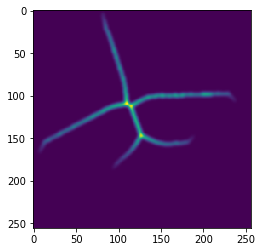

In [22]:
plt.imshow(X_array[0][0])

In [40]:
Y_array[0]

array([[  0., 114., 116.,   3., 232.],
       [  0., 109., 110.,   3., 201.],
       [  0., 148., 128.,   3., 331.],
       [  0.,  13.,  84.,   1., 430.],
       [  0., 100., 231.,   1., 431.],
       [  0., 156., 181.,   1., 432.],
       [  0., 159.,  12.,   1., 433.],
       [  0., 177., 102.,   1., 434.]])

In [41]:
Edge_array[0]

array([[232., 201.],
       [232., 331.],
       [232., 431.],
       [201., 433.],
       [201., 430.],
       [331., 432.],
       [331., 434.]])

No handles with labels found to put in legend.


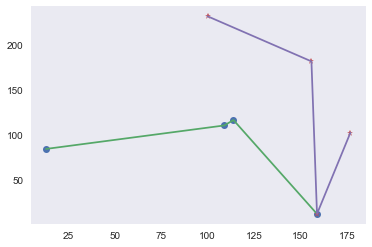

In [127]:
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import bezier
import seaborn

x1 = np.array([13, 109, 114, 159])
fx1 = np.array([84, 110, 116, 12])
# k Degree 3 Beizer curves
spl1 = interpolate.splrep(x1, fx1, k=3)
spline1 = interpolate.splev(x1, spl1)

x2 = np.array([100, 156, 159, 177])
fx2 = np.array([231, 181, 12, 102])
# k Degree 3 Beizer curves
spl2 = interpolate.splrep(x2, fx2, k=3)
spline2 = interpolate.splev(x2, spl2)

plt.plot(x1, fx1, 'o', x1, spline1)
plt.plot(x2, fx2, '*', x2, spline2)
#plt.plot(x, spline, 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

In [33]:
def edge_array_to_adj_list(edge_array):
    """
    Given an edge array, convert it into an adj list 
    representation of the graph.
    edge_array = 
    array([[232., 201.],
       [232., 331.],
       [232., 431.],
       [201., 433.],
       [201., 430.],
       [331., 432.],
       [331., 434.]])
    """
    adj_lists = []
    for i in range(len(edge_array)):
        adj_list = {}
        for j in range(len(edge_array[i])):
            start_node = edge_array[i][j][0]
            end_node = edge_array[i][j][1]
            if start_node in adj_list:
                adj_list[start_node].append(end_node)
            else:
                adj_list[start_node] = [end_node]
        adj_lists.append(adj_list)
    return adj_lists

def Y_array_to_coordinate_map(Y_array):
    """
    Y_array = 
    array([[  0., 114., 116.,   3., 232.],
       [  0., 109., 110.,   3., 201.],
       [  0., 148., 128.,   3., 331.],
       [  0.,  13.,  84.,   1., 430.],
       [  0., 100., 231.,   1., 431.],
       [  0., 156., 181.,   1., 432.],
       [  0., 159.,  12.,   1., 433.],
       [  0., 177., 102.,   1., 434.]])
       
    Coordinate
    """

def build_path(adj_list, Y_array):
    """
    Given an adj list, find all paths using dfs
    Y_array = 
    array([[  0., 114., 116.,   3., 232.],
       [  0., 109., 110.,   3., 201.],
       [  0., 148., 128.,   3., 331.],
       [  0.,  13.,  84.,   1., 430.],
       [  0., 100., 231.,   1., 431.],
       [  0., 156., 181.,   1., 432.],
       [  0., 159.,  12.,   1., 433.],
       [  0., 177., 102.,   1., 434.]])
    adj_list = {201.0: [433.0, 430.0], 232.0: [201.0, 331.0, 431.0], 331.0: [432.0, 434.0]}
    """
    visited = []
    for node in adj_list:
        dfs(adf_list, Y_array, visited, [], node)
    return visited
    
def dfs(adj_list, Y_array, visited, path, node):
    if not node in adj_list:
        if path not in visited:
            visited.append(path)
        return
    neighbors = adj_list[node]
    neighbor in neighbors
    

In [35]:
adj_lists = edge_array_to_adj_list(Edge_array)

In [129]:
adj_lists[:5]

[{201.0: [433.0, 430.0], 232.0: [201.0, 331.0, 431.0], 331.0: [432.0, 434.0]},
 {201.0: [433.0, 430.0], 232.0: [201.0, 331.0, 431.0], 331.0: [432.0, 434.0]},
 {47.0: [344.0, 317.0],
  65.0: [64.0, 47.0],
  69.0: [64.0, 346.0],
  224.0: [225.0, 349.0, 345.0],
  225.0: [230.0],
  226.0: [64.0, 230.0],
  230.0: [351.0]},
 {46.0: [339.0, 340.0],
  110.0: [281.0, 341.0, 46.0],
  281.0: [283.0],
  282.0: [283.0],
  344.0: [282.0],
  345.0: [283.0]},
 {84.0: [153.0],
  153.0: [414.0],
  496.0: [84.0],
  497.0: [153.0],
  498.0: [84.0],
  499.0: [414.0],
  500.0: [414.0]}]

In [8]:
X_train = None
for x in X_array:
    x = np.expand_dims(x, axis=3)
    if X_train is None:
        X_train = x
    else:
        X_train = np.concatenate([X_train, x], axis=0)

In [9]:
X_train.shape

(512, 256, 256, 1)

In [10]:
writeh5("SK-LARGE-test-labels.h5", X_train)

In [11]:
max_points = 0
for y in Y_array:
    max_points = max(max_points, y.shape[0]) 

# For dataset with less than max_points points, 
# We sample some replications from the dataset to fill in the gap
for i in range(len(Y_array)):
    y = Y_array[i]
    num_points = y.shape[0]

    if num_points < max_points:
        diff = max_points - num_points
        indexes = np.random.choice(range(num_points), size=diff)
        
        for index in indexes:
            sample = np.copy(y[index])
            sample.shape = (-1, y.shape[1])
            y = np.concatenate([y, sample], axis=0)
            
    y = np.expand_dims(y, axis=0)
            
    Y_array[i] = y
    

In [12]:
Y_train = None

for i in range(len(Y_array)):
    y = Y_array[i]
    if Y_train is None:
        Y_train = y
    else:
        Y_train = np.concatenate([Y_train, y], axis=0)

In [13]:
Y_train.shape

(512, 34, 5)

In [15]:
writeh5("SK-LARGE-test-train.h5", Y_train)

In [ ]:
Y_train = None

for i in range(len(Y_array)):
    y = Y_array[i]
    if Y_train is None:
        Y_train = y
    else:
        Y_train = np.concatenate([Y_train, y], axis=0)

## Creat heatmap training points and labels.

In [ ]:
dir_img = "SK-LARGE-MIX-GAUSSIAN/"
dir_degrees = "SK-LARGE-MIX-GAUSSIAN-DEGREES/"
dir_pos = "SK-LARGE-MIX-GAUSSIAN-POS/"
dir_radius = "SK-LARGE-MIX-GAUSSIAN-RADIUS/"

X_array = []
Y_array = []

for i in range(745):
    try:
        img_h5 = readh5(dir_img + str(i) + ".h5")
        degrees_h5 = readh5(dir_degrees + str(i) + ".h5")
        pos_h5 = readh5(dir_pos + str(i) + ".h5")
        radius_h5 = readh5(dir_radius + str(i) + ".h5")
        
        for i in range(degrees_h5.shape[0]):
            data = degrees_h5[i]
            
        
        print(img_h5.shape)
        print(degrees_h5)
        print(degrees_h5.shape)
        print(pos_h5.shape)
        print(pos_h5)
        print(radius_h5.shape)
        
        break;
        
        
    except:
        # No such file exists. This means when using Ibexhelper to process the original heatmap files
        # into nodes and skeletons there are some mistakes.
     #   print("exception")
        continue